In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import shap
import joblib
from models.jm_nn import MLP
from models.jm_lstm_template import simpleLSTM
from captum.attr import GradientShap


In [4]:
# inputs
#model_path = 'lstm_base.pt'
model_path = 'lstm_base_CV0.pt'
col_path = 'column.pkl'
device = torch.device('cpu')
xtest_name = 'xtestCV0.pkl'
xtest = joblib.load(xtest_name)
col_names = joblib.load(col_path)
model_type = 'lstm'

# load the model with the last best current weights
if model_type == 'mlp':
    model = MLP(hidden_size=20,
                dropout=.30,
                input_dim=48)
    model.load_state_dict(torch.load(model_path))

if model_type == 'lstm':
    model = simpleLSTM(hidden_dim=20,
                       dropout_rate=.20,
                       input_dim=8)
    model.load_state_dict(torch.load(model_path))
    
#####################################################
if isinstance(xtest, np.ndarray):
    xtest = torch.tensor(xtest,
                         dtype=torch.float32,
                         device=device,
                         requires_grad=True)

# explainer
explainer = GradientShap(model)
baselines = torch.zeros(xtest.shape,
                        device=device,
                        dtype=torch.float32)

print(xtest.shape)

# attribution 
attribution = explainer.attribute(xtest, baselines, target=62)

if model_type == 'lstm':
    attribution = attribution[:, -1, :]
    xtest = xtest[:, -1, :]

# store a numpy example as well
xtest2 = xtest.cpu().detach().numpy()


torch.Size([2989, 63, 8])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


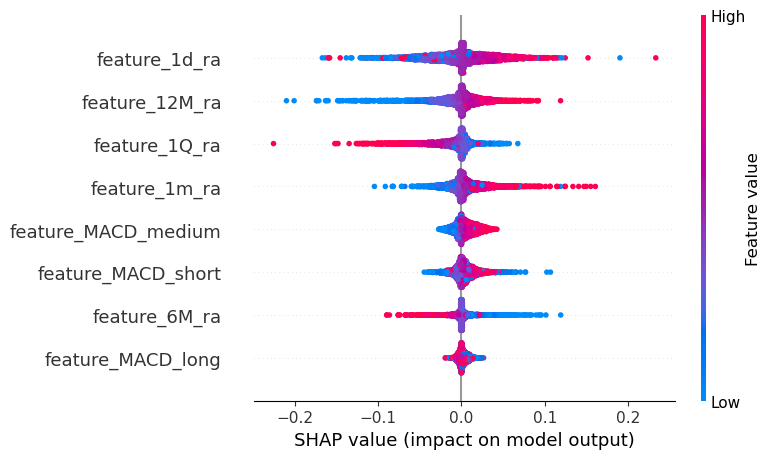

In [5]:
# let's show the basic shape summary plot
attribution = attribution.cpu().detach().numpy()
shap.summary_plot(attribution, xtest2, feature_names=col_names)

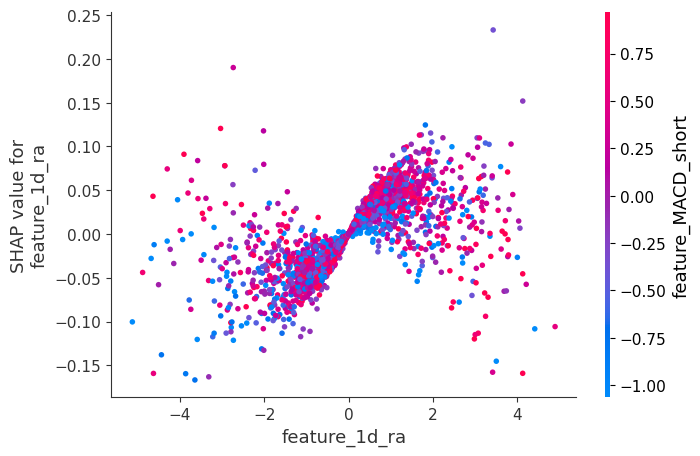

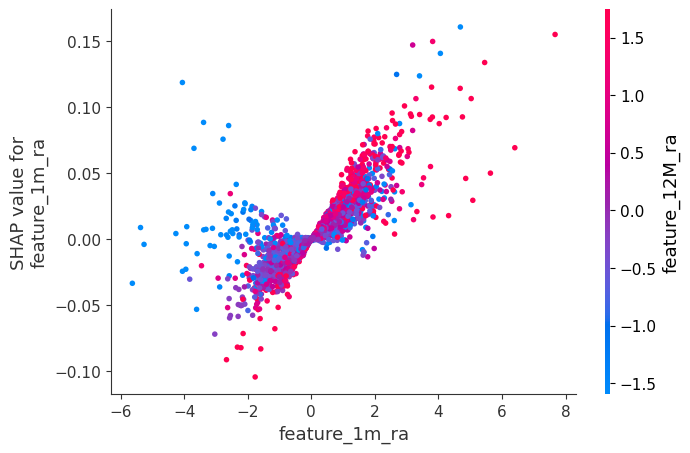

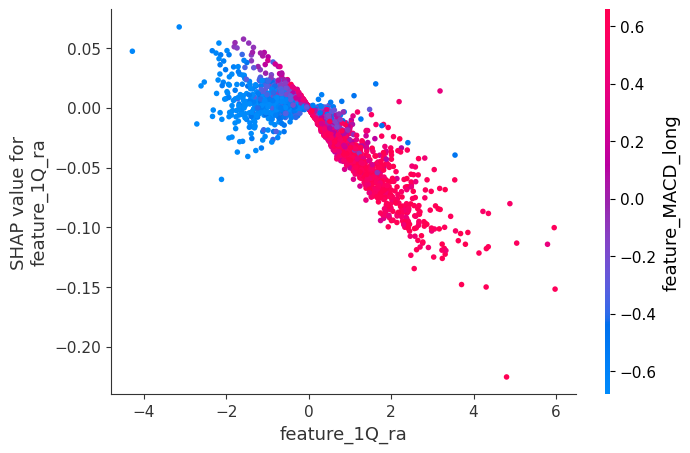

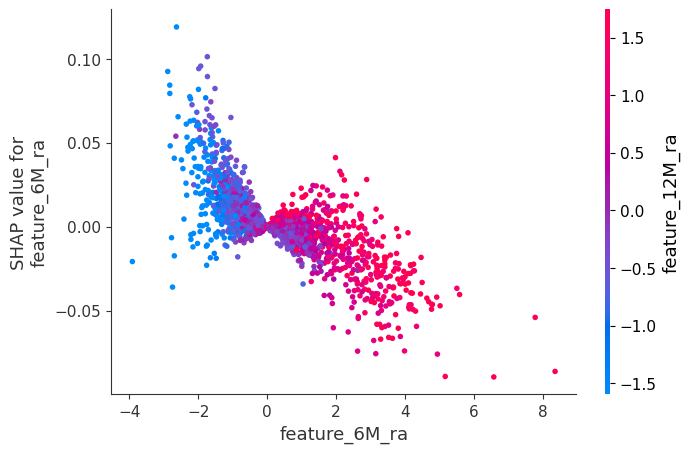

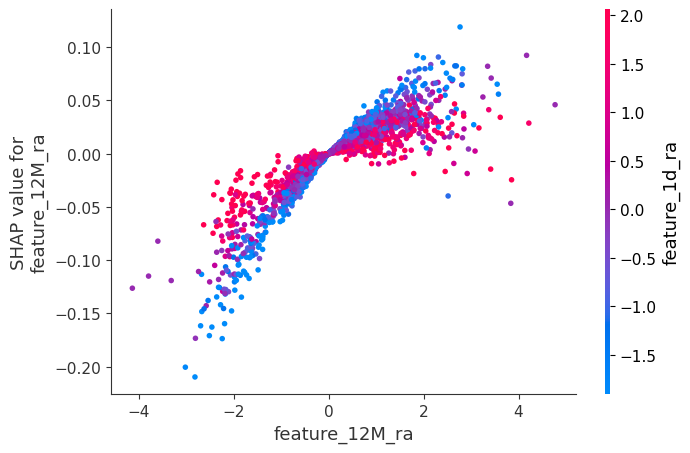

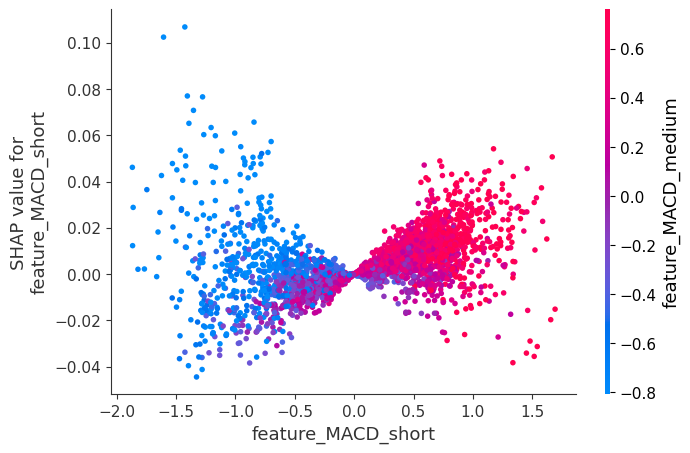

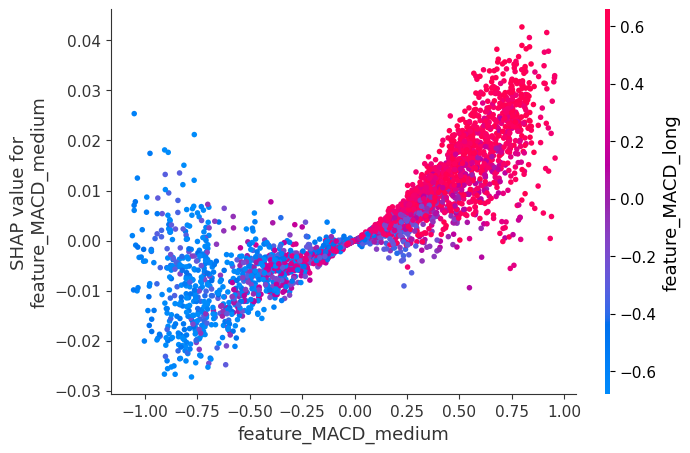

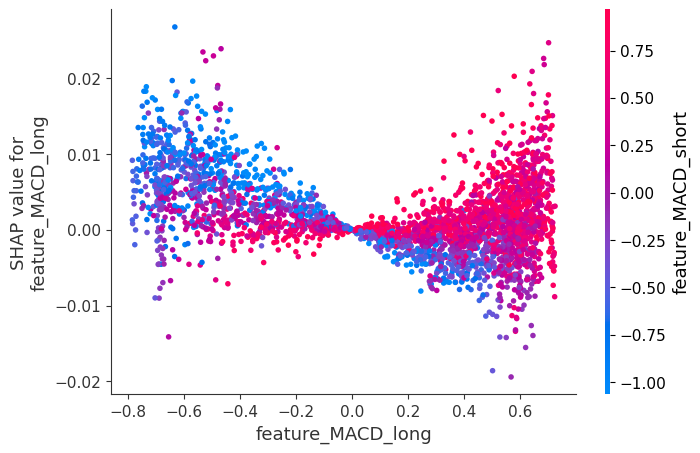

In [6]:
# loop through and show the SHAP dependence plot
for col in col_names:
    shap.dependence_plot(col,
                         attribution,
                         xtest2,
                         feature_names=col_names)